# Mask Classifier - Version 3 - PART 1

### You can find the free to use application at https://protected-mountain-28715.herokuapp.com. 

#### Author: Nikolaos Toumpanakis

Email: toump.nick@gmail.com
GitHub: https://github.com/ntoump/
Youtube: https://www.youtube.com/channel/UCFgF1lHh0fRQxY9CqpyBZgw

## Training Walkthrough

I should mention that, in this Walkthrough, _as well as in the above deployed application,_ I use __Multi-Label Classification__ (specifically __one hot encoding__), so that many categories can be output as prediction for each image.

### Imports

In [7]:
#hide

# Standard imports
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
from utils import *
torch.cuda.empty_cache()
from fastai.vision.all import *

In [8]:
#hide

# Good GPU debugging tools
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
t, c, a
# f = c-a  # free inside cache

(8521711616, 0, 0)

### Data

In [11]:
df = pd.read_csv('CSVs/only_images4.csv')
df

fname    labels
0      C001.jpg     Cloth
1      C002.jpg     Cloth
2      C003.jpg     Cloth
3      C004.jpg     Cloth
4      C005.jpg     Cloth
...         ...       ...
1011  No094.jpg  No_mask!
1012  No096.jpg  No_mask!
1013  No097.jpg  No_mask!
1014  No099.jpg  No_mask!
1015  No100.jpg  No_mask!

[1016 rows x 2 columns]

In [12]:
#hide
path = Path('/notebooks/images/all_extra/aller')
def get_x(r): return path/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/notebooks/images/all_extra/aller/A190.jpg'), ['Shield', 'Surgical'])

# First try

This is my first try (of the "masksv3" - 3rd Version) at creating an improved model using  Deep Convolutional Neural Networks, continuing where "masksv2" left off.

In comparison to the previous Version, in this first try I only changed the dataset, filtering out many mislabeled images and adding a few, _as well as customizing my previous dataset to support __one hot encoding___. At the same time, everything else (e.g. the hyperparameters) is left as is.

After reviewing the final accuracy of this first model, I'll try to improve on that by tweaking the hyperparameters.

Wish me luck!

In [1]:
# Get dblock, dsets, and dls
# Notice that no Presizing is used (all credits to fastai for their incredible work) in this first DataBlock
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dsets = dblock.datasets(df)
dls = dblock.dataloaders(df)

NameError: name 'DataBlock' is not defined

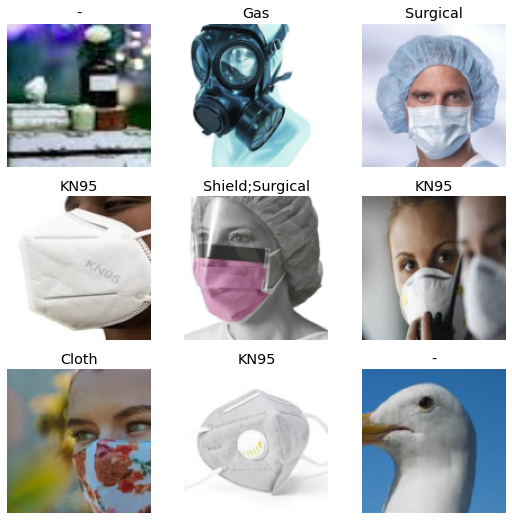

In [16]:
# Everything looks good
dls.show_batch()

## Training

You can see that I start off with a small threshold (0.2), and a semi-random base learning rate.
Furthermore, I train using _fine_tune,_ because it could be a good starting point to begin to understand what the differences are (in practical terms and applications) between the fastai model training tools (including _fit,_ _fit_one_cycle,_ and _fine_tune)._

### First set of epochs

In [17]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

The accuracy seems to have improved greatly in a few seconds _(because of using a P5000 NVIDIA GPU)_ and epochs of training, which indicates that there was plenty of room to grow

Next, I sketch the lr to loss relationship, and get the suggested lrs, in order to train even further with a better informed lr guess.

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.0006918309954926372)

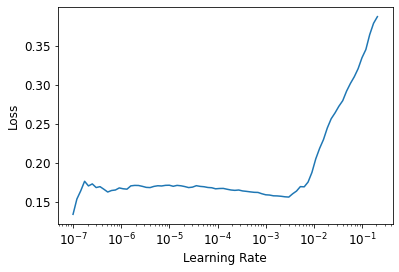

In [18]:
learn.lr_find()

There does not seem to be a clear slope downwards, that's why I'll just use the lr_min.

### Second set of epochs

In [19]:
learn.fine_tune(3, base_lr=0.0003019951749593019, freeze_epochs=4)

The accuracy has skyrocketed to almost 94%. Thus far, I can say that we've done pretty well.

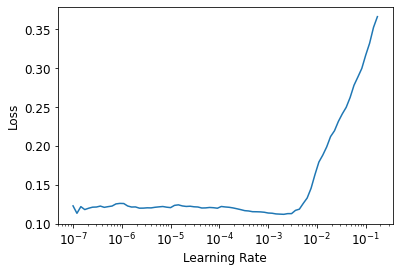

In [20]:
lr_min, lr_steep = learn.lr_find()

Let's train some more.

### Third and final set of epochs

In [21]:
learn.fine_tune(2, base_lr=lr_min)

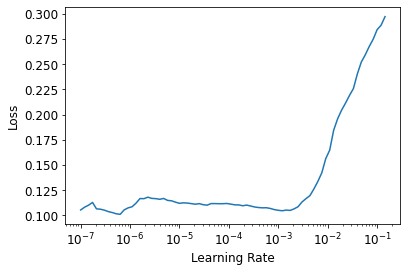

In [22]:
lr_min, lr_steep = learn.lr_find()

Not bad! We just saw, for the first time, a __decrease in accuracy__ (something that I was expecting, that's why I trained it only a few epochs per set). That's not necessarily a sign of overfitting. It would be a good opportunity, though, to get the predictions of the model, and plot the threshold to accuracy relationship.

In [28]:
preds,targs = learn.get_preds()

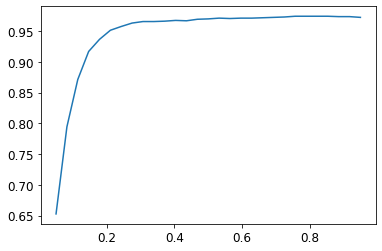

In [24]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

The above plot shows that there is a positive relationship between threshold and accuracy. Therefore, the higher is the chosen threshold, the higher is expected to be the accuracy of the model. It is also important to note that there isn't such a great difference between choosing, say, 0.3 and 0.85 as your threshold, perhaps not even a percentage point.

# First try - Review
I am fairly impressed by the model's performance. Reaching 95% accuracy, considering the variation of the ds __*__, the limited training time (& costs), and the uncustomized hyperparameter choices, is almost excellent.

Now onwards to manual testing.

I have a few dozen images, against which I will check my model's accuracy. These are the ones used for evaluating the masksv2 application's model as well.

__*__: The dataset contains, at this point, __seven (#7+1) distinct categories__, namely: (#7)                                      ['-','Cloth','Gas','KN95','Medical','No_mask!','Shield', __'Surgical'__].

Each category refers to a type of face mask, except for "-" and "No_mask!". The last one suggests that there is a maskless face in the given image, whereas the first one ("-") is part of an experiment I conduct named __"Intended Noise"__ (see below).

## Manual Testing

I have three folders of images for my manual testing: "NEW", "NEU", and all the other pictures you see below.

[The names of the images are supposed to be related to their content, while that is not always necessarily the case.]

In [31]:
ls

NEU/  c.jpg   c1.jpg  c3.jpg  f.jpg    ff0.jpg  kn.jfif   kn1.jfif  kn3.jfif
NEW/  c0.jpg  c2.jpg  c4.jpg  ff.jfif  k.jfif   kn0.jfif  kn2.jpg   m.jpg


In [37]:
# Built a quick loop to do the work for me
# Below you can see the predictions of the model

import os

pather = Path('/notebooks/Manual')

for img in os.listdir(pather):
    if not img[0] == '.':
        if not img[0].isupper():
            print(img, learn.predict(img))

c.jpg ((#1) ['Surgical'], tensor([False, False, False, False, False, False, False,  True]), tensor([0.0775, 0.1155, 0.0063, 0.0130, 0.0673, 0.0341, 0.2313, 0.9998]))


c0.jpg ((#2) ['Cloth','Surgical'], tensor([False,  True, False, False, False, False, False,  True]), tensor([0.0728, 0.9934, 0.0024, 0.0257, 0.2283, 0.0275, 0.0254, 0.7986]))


c1.jpg ((#1) ['Cloth'], tensor([False,  True, False, False, False, False, False, False]), tensor([0.1199, 0.9999, 0.0045, 0.0559, 0.1601, 0.0538, 0.0173, 0.0220]))


c2.jpg ((#2) ['Cloth','Surgical'], tensor([False,  True, False, False, False, False, False,  True]), tensor([0.0886, 0.9984, 0.0017, 0.0033, 0.1045, 0.0977, 0.2173, 0.6740]))


c3.jpg ((#1) ['Cloth'], tensor([False,  True, False, False, False, False, False, False]), tensor([0.0635, 1.0000, 0.0062, 0.0124, 0.1405, 0.0456, 0.0129, 0.0107]))


c4.jpg ((#1) ['KN95'], tensor([False, False, False,  True, False, False, False, False]), tensor([0.0337, 0.4820, 0.0034, 0.9528, 0.1218, 0.0256, 0.0292, 0.2378]))


f.jpg ((#1) ['Shield'], tensor([False, False, False, False, False, False,  True, False]), tensor([9.1857e-02, 1.9036e-02, 7.7392e-04, 4.6145e-03, 9.7188e-02, 8.0676e-03, 1.0000e+00, 1.9384e-01]))


ff.jfif ((#2) ['Gas','KN95'], tensor([False, False,  True,  True, False, False, False, False]), tensor([0.0387, 0.0341, 0.9998, 0.7817, 0.1651, 0.0845, 0.0285, 0.0202]))


ff0.jpg ((#2) ['Shield','Surgical'], tensor([False, False, False, False, False, False,  True,  True]), tensor([0.0545, 0.0850, 0.0047, 0.1072, 0.2291, 0.0347, 0.9999, 1.0000]))


k.jfif ((#2) ['Cloth','Shield'], tensor([False,  True, False, False, False, False,  True, False]), tensor([0.0819, 0.9689, 0.0013, 0.1041, 0.1234, 0.0768, 0.6258, 0.0066]))


kn.jfif ((#1) ['KN95'], tensor([False, False, False,  True, False, False, False, False]), tensor([0.0695, 0.0832, 0.0131, 0.5997, 0.2483, 0.0758, 0.0988, 0.1063]))


kn0.jfif ((#1) ['KN95'], tensor([False, False, False,  True, False, False, False, False]), tensor([0.0559, 0.1427, 0.0032, 0.9986, 0.1310, 0.0318, 0.0668, 0.0511]))


kn1.jfif ((#1) ['KN95'], tensor([False, False, False,  True, False, False, False, False]), tensor([0.1210, 0.0280, 0.0057, 1.0000, 0.1297, 0.0482, 0.0182, 0.0055]))


kn2.jpg ((#2) ['KN95','Surgical'], tensor([False, False, False,  True, False, False, False,  True]), tensor([0.0345, 0.0628, 0.0126, 0.5065, 0.1243, 0.0679, 0.0438, 0.9757]))


kn3.jfif ((#1) ['KN95'], tensor([False, False, False,  True, False, False, False, False]), tensor([0.0193, 0.0180, 0.0032, 1.0000, 0.1066, 0.0293, 0.0219, 0.0073]))


m.jpg ((#1) ['Surgical'], tensor([False, False, False, False, False, False, False,  True]), tensor([0.0604, 0.0252, 0.0092, 0.0068, 0.1327, 0.1073, 0.0532, 1.0000]))


In [46]:
for img in os.listdir(pather/'NEW'):
    print(img, learn.predict(img))

0.jpg ((#1) ['Cloth'], tensor([False,  True, False, False, False, False, False, False]), tensor([0.2064, 0.7891, 0.0167, 0.0831, 0.1360, 0.0263, 0.1972, 0.0074]))


1.jpg ((#1) ['Medical'], tensor([False, False, False, False,  True, False, False, False]), tensor([0.0397, 0.0667, 0.0052, 0.0510, 0.8644, 0.0356, 0.0485, 0.0339]))


10.jpg ((#2) ['Cloth','Surgical'], tensor([False,  True, False, False, False, False, False,  True]), tensor([0.0320, 0.9658, 0.0103, 0.1079, 0.3641, 0.0235, 0.0414, 0.6926]))


100.jpg ((#2) ['Cloth','Medical'], tensor([False,  True, False, False,  True, False, False, False]), tensor([0.0284, 0.9688, 0.0715, 0.4539, 0.9123, 0.2135, 0.0244, 0.0144]))


3.jpg ((#1) ['Medical'], tensor([False, False, False, False,  True, False, False, False]), tensor([0.0089, 0.1283, 0.0151, 0.3042, 0.9984, 0.1028, 0.0139, 0.0350]))


30.jpg ((#3) ['Cloth','KN95','Medical'], tensor([False,  True, False,  True,  True, False, False, False]), tensor([0.0420, 0.9991, 0.0048, 0.6708, 0.9817, 0.0964, 0.0404, 0.0023]))


In [53]:
for img in os.listdir(pather/'NEU'):
    print(img, learn.predict(img))

f.jpg ((#1) ['No_mask!'], tensor([False, False, False, False, False,  True, False, False]), tensor([0.0688, 0.0212, 0.0060, 0.0261, 0.1245, 1.0000, 0.0367, 0.0180]))


f0.jpg ((#1) ['No_mask!'], tensor([False, False, False, False, False,  True, False, False]), tensor([0.0323, 0.0214, 0.0043, 0.0135, 0.0879, 1.0000, 0.0364, 0.0129]))


f1.jpg ((#1) ['No_mask!'], tensor([False, False, False, False, False,  True, False, False]), tensor([0.0420, 0.0315, 0.0054, 0.0091, 0.0844, 1.0000, 0.0286, 0.0094]))


f2.jpg ((#1) ['No_mask!'], tensor([False, False, False, False, False,  True, False, False]), tensor([0.0301, 0.0200, 0.0069, 0.0065, 0.1041, 1.0000, 0.0287, 0.0204]))


f3.jpg ((#1) ['No_mask!'], tensor([False, False, False, False, False,  True, False, False]), tensor([0.0465, 0.0427, 0.0093, 0.0152, 0.1351, 1.0000, 0.0774, 0.0113]))


f4.jpg ((#1) ['No_mask!'], tensor([False, False, False, False, False,  True, False, False]), tensor([0.0402, 0.0260, 0.0057, 0.0118, 0.0923, 1.0000, 0.0645, 0.0311]))


f5.jpg ((#1) ['No_mask!'], tensor([False, False, False, False, False,  True, False, False]), tensor([0.0531, 0.0342, 0.0030, 0.0058, 0.1081, 1.0000, 0.0260, 0.0279]))


i0.jpg ((#1) ['-'], tensor([ True, False, False, False, False, False, False, False]), tensor([0.9999, 0.0137, 0.0048, 0.0347, 0.0524, 0.0716, 0.0443, 0.0584]))


i1.jpg ((#1) ['-'], tensor([ True, False, False, False, False, False, False, False]), tensor([0.9998, 0.2033, 0.0035, 0.0099, 0.0363, 0.0421, 0.0947, 0.0159]))


i2.jpg ((#2) ['-','Shield'], tensor([ True, False, False, False, False, False,  True, False]), tensor([0.9941, 0.1205, 0.0118, 0.0185, 0.1548, 0.0936, 0.5295, 0.0373]))


i3.jpg ((#1) ['-'], tensor([ True, False, False, False, False, False, False, False]), tensor([1.0000, 0.0770, 0.0095, 0.0109, 0.1565, 0.0578, 0.0114, 0.0063]))


i4.jpg ((#1) ['-'], tensor([ True, False, False, False, False, False, False, False]), tensor([1.0000, 0.0118, 0.0027, 0.0067, 0.1234, 0.1374, 0.0240, 0.0239]))


l0.jpg ((#1) ['-'], tensor([ True, False, False, False, False, False, False, False]), tensor([1.0000, 0.0766, 0.0029, 0.0092, 0.0801, 0.0751, 0.0630, 0.0171]))


l1.jpg ((#2) ['-','Cloth'], tensor([ True,  True, False, False, False, False, False, False]), tensor([1.0000, 0.8937, 0.0038, 0.1679, 0.3973, 0.0362, 0.0091, 0.0034]))


l2.jpg ((#1) ['-'], tensor([ True, False, False, False, False, False, False, False]), tensor([1.0000, 0.1106, 0.0068, 0.0163, 0.1903, 0.0247, 0.0390, 0.0029]))


l3.jpg ((#1) ['-'], tensor([ True, False, False, False, False, False, False, False]), tensor([1.0000, 0.0251, 0.0066, 0.0144, 0.1485, 0.0422, 0.0181, 0.0456]))


l4.jpg ((#1) ['-'], tensor([ True, False, False, False, False, False, False, False]), tensor([1.0000, 0.2441, 0.0053, 0.0287, 0.0584, 0.0346, 0.0988, 0.0175]))


## Manual Check - Review

### Spare images
The model did not do particularly well with the spare images. I'll get back to that very soon.

### "NEW"
The "NEW" folder contains images with many people wearing masks, rather than just one person at a time _(the dataset contained only such images at this point; with one (mostly) mask per image)_. It was at this point, while reviewing these results, that I realized my __blunder__; I had included two categories in the dataset __for the same masks__ (namely, "Surgical" and "Medical").

This was obviously done by accident, as I had not found a comfortable GUI to clean the data (the fastai one does not work for multi-label classification), therefore I had to do it by hand. That gave me, nontheless, an __idea__; what if I included all "Surgical" images with the "Medical" labeled ones into a common category, named "Medical" (__To be continued...__)?

### "NEU"
Now that's where the model __really shined__. You see, the images in this category are part of what I call __"Intended Noise"__ (DISCLAIMER: I have not encountered this idea anywhere in DL, that's why I have taken the liberty of naming it, and I don't provide citation. If anyone knows if that's a thing, please reach out to me with the relevant sources!).

I'm not going to delve into that in this post. Keep an eye out for that, though, because a detailed approach to explaining this idea, as well as its potential benefits to DL models, will be posted soon.

## Interpretation

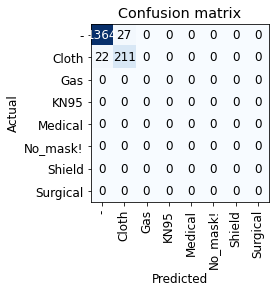

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

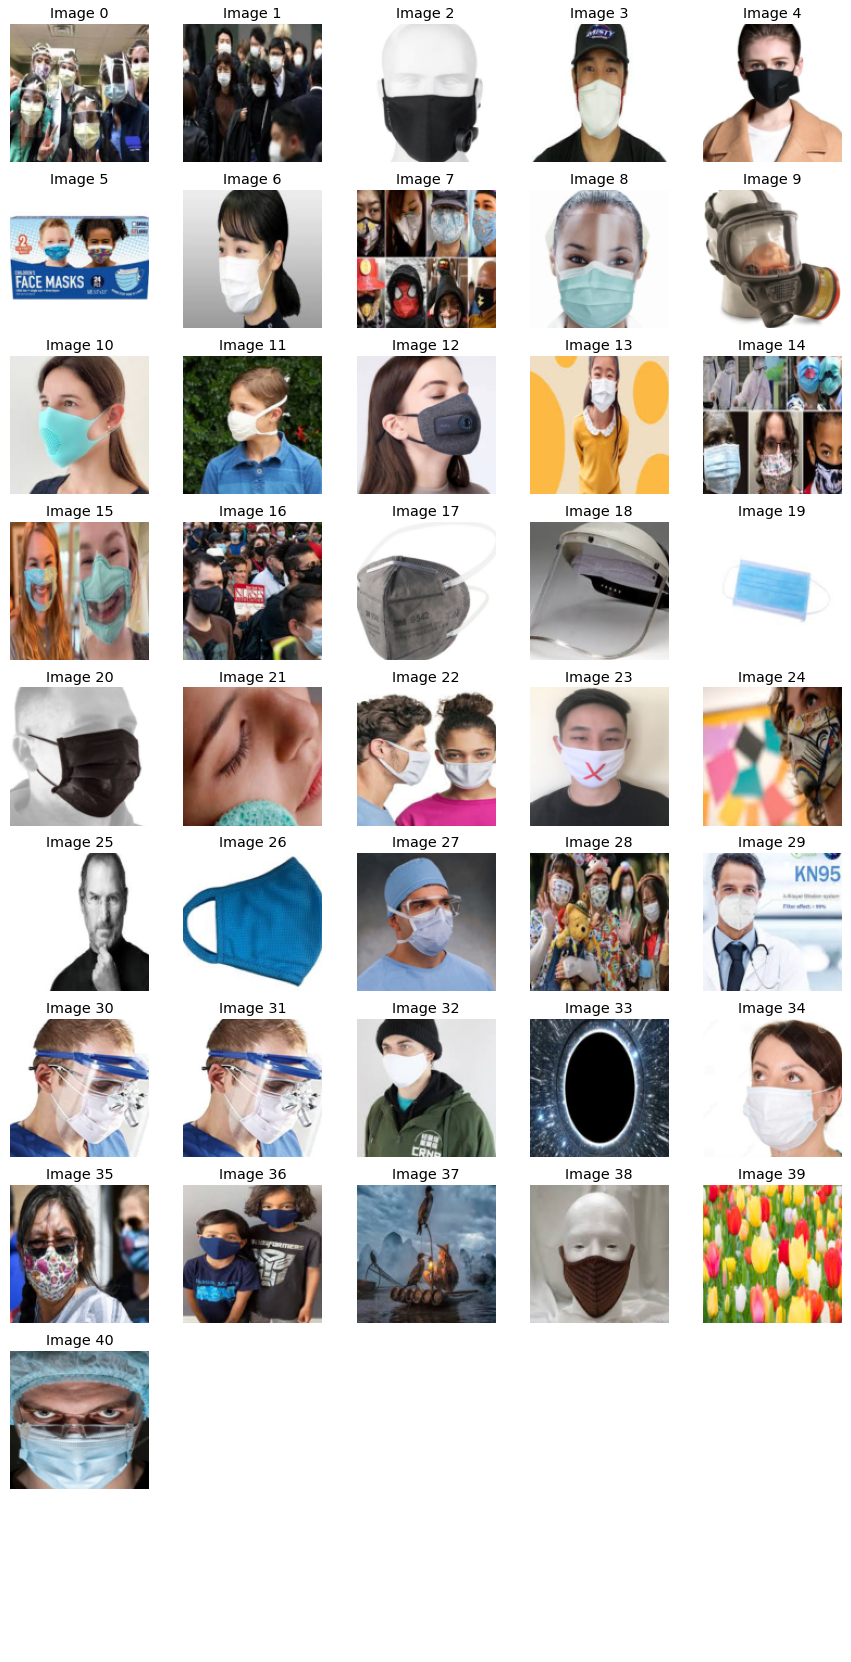

In [49]:
interp.plot_top_losses(41, nrows=10)

After interpreting the results (for some wicked reason I can't seem to get the "Confusion matrix" to work with my ds) by viewing the top losses, I realize that the model misses a few easy ones, all the while being extremely accurate to useless datapoints _(more on that later)._

- It should be noted that I __DID NOT__ train the first model until overfitting. I stopped mainly because I had ideas I deemed more valuable to explore, and because of the threshold to accuracy relationship, which suggested that the model is almost as good as possible. __Nowadays, I tend to dismiss such early stoppings, given that these ploted relationships are but predictions.__

# Second Try
Firstly, I cleaned the ds, as I thought I had done earlier. I merged the "Surgical" and "Medical" categories into "Medical", and relabeled a few misclassified items.

In continuation, I will tweak slightly the hyperparameters to try to achieve better performance than the above reached (~95%), including cropping to a bigger size (224 to start with) and using Presizing, using a deeper arch, and adjusting the threshold/lr.

__Note__: I deleated the 224 crop results accidentally during training. It was slightly better than the above reached accuracy, even though only by a percentage point (~96%). I have included, though, below the next stage; applying Presizing with far higher resolution in the hopes of achieving near perfect accuracy. 

## Data

In [6]:
df = pd.read_csv('CSVs/only_images4.csv')
df

fname    labels
0      C001.jpg     Cloth
1      C002.jpg     Cloth
2      C003.jpg     Cloth
3      C004.jpg     Cloth
4      C005.jpg     Cloth
...         ...       ...
1009  No094.jpg  No_mask!
1010  No096.jpg  No_mask!
1011  No097.jpg  No_mask!
1012  No099.jpg  No_mask!
1013  No100.jpg  No_mask!

[1014 rows x 2 columns]

In [7]:
path = Path('/notebooks/images/all_extra/aller')
def get_x(r): return path/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/notebooks/images/all_extra/aller/K189.jpg'), ['KN95'])

In [13]:
# Here is the main difference of this time; use of Presizing (720->460), in the hopes of higher accuracy due to higher resolution 

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(720),
                   
                   batch_tfms=aug_transforms(size=460, min_scale=0.75))

dsets = dblock.datasets(df)

# I got a CUDA memory error; that's why the batch size had to be smaller than 64, and I traditionally chose 32
dls = dblock.dataloaders(df, bs=32)

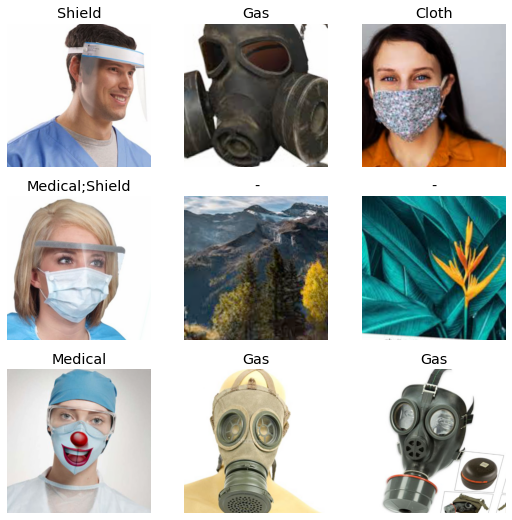

In [14]:
dls.show_batch()

## Training

In [15]:
# Threshold = 0.8 (instead of 0.2)
learn0 = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.8))

I tried to first get the lr_min, in order to better direct the training. Pretty much expected curve

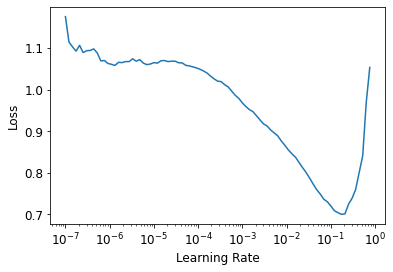

In [16]:
lr_min, lr_steep = learn0.lr_find()

### Cuda memory error

In [17]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
# f = c-a  # free inside cache
t, c, a

/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/cuda/memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


(17069309952, 14545846272, 112194560)

### First set of epochs

In [18]:
learn0.fine_tune(3, base_lr=lr_min, freeze_epochs=3)

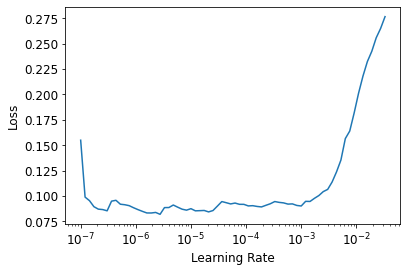

In [27]:
lr_min, lr_st = learn0.lr_find()

### Second set of epochs

In [28]:
learn0.fine_tune(2, base_lr=lr_min, freeze_epochs=3)

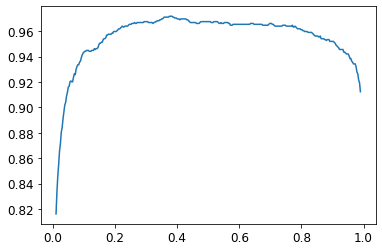

In [29]:
preds,targs = learn0.get_preds()
xs = torch.linspace(0.01,0.99,350)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

### Third and final set of epochs


In [24]:
learn0.fine_tune(2, base_lr=lr_min, freeze_epochs=2)

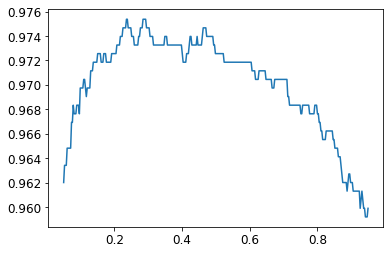

In [42]:
preds,targs = learn0.get_preds()
xs = torch.linspace(0.05,0.95,350)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

I increase the number of points to search from up to 350. The difference in plot shapes is obvious, albeit of limited practical importance.

## Interpretation

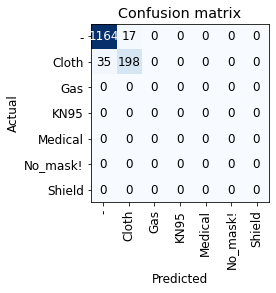

In [22]:
interp = ClassificationInterpretation.from_learner(learn0)
interp.plot_confusion_matrix()

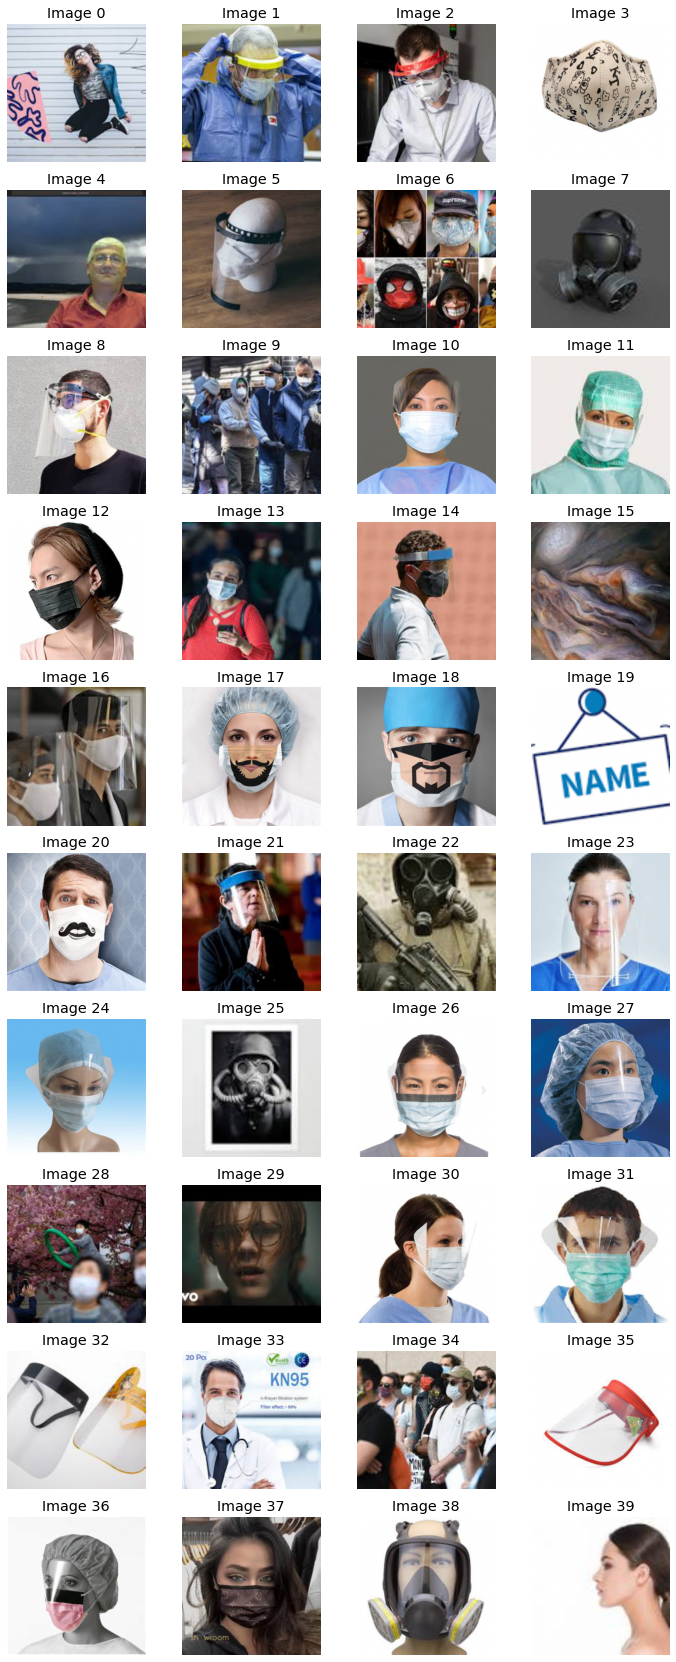

In [23]:
interp.plot_top_losses(40, nrows=10)

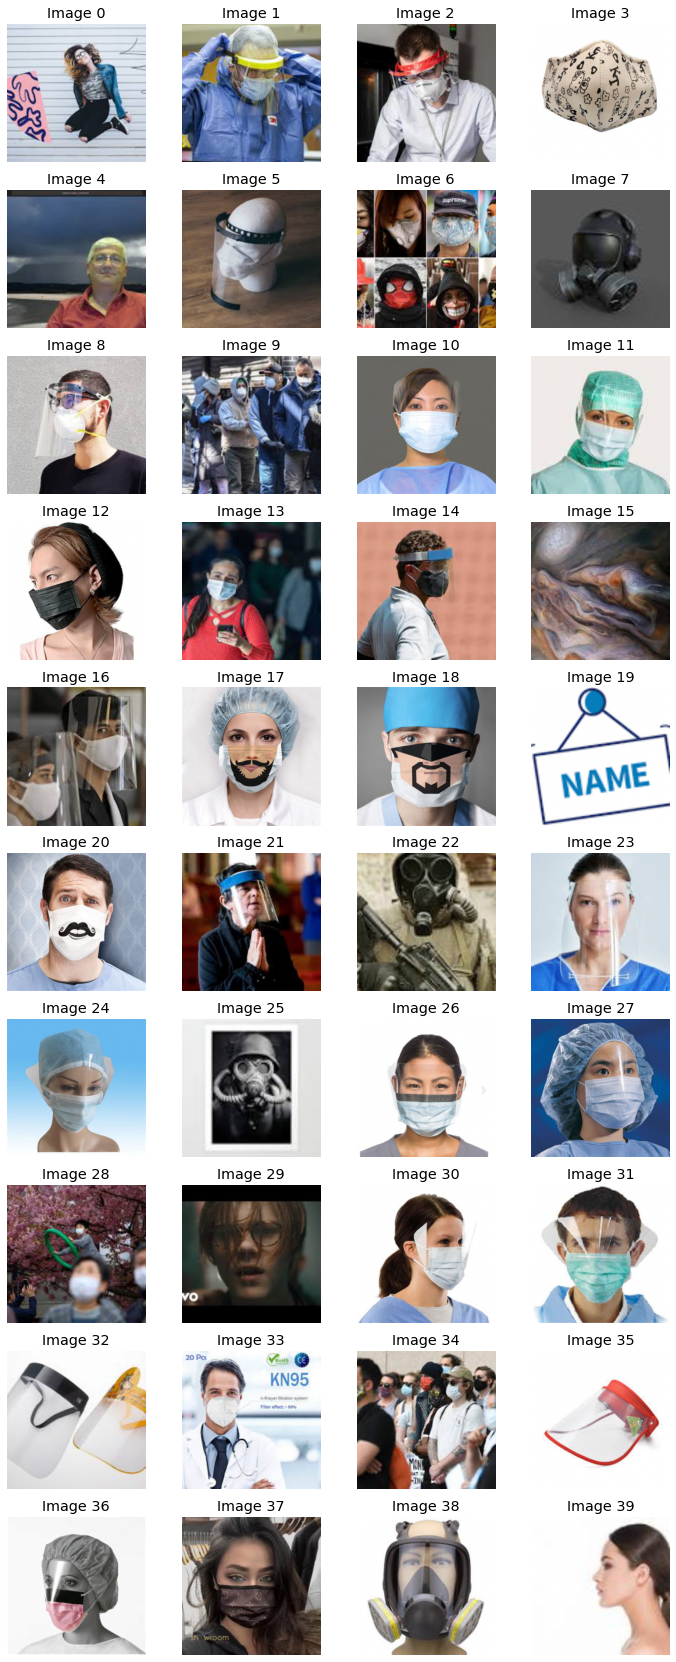

In [30]:
interp0 = ClassificationInterpretation.from_learner(learn0)
interp.plot_top_losses(40, nrows=10)

## Manual Testing

In [35]:
learn0.predict('WhatsApp Image 2020-09-13 at 8.34.08 PM.jpeg')

((#1) ['KN95'],
 tensor([False, False, False,  True, False, False, False]),
 tensor([3.7567e-04, 1.4866e-02, 1.9021e-03, 9.3934e-01, 1.2692e-03, 6.1743e-02, 1.6483e-03]))

In [36]:
learn0.predict('WhatsApp Image 2020-09-13 at 8.34.23 PM.jpeg')

((#1) ['KN95'],
 tensor([False, False, False,  True, False, False, False]),
 tensor([1.9798e-04, 2.5388e-03, 7.8868e-04, 9.8569e-01, 4.1836e-03, 1.0470e-03, 1.8771e-03]))

In [39]:
learn0.predict('family.jpg')

((#0) [],
 tensor([False, False, False, False, False, False, False]),
 tensor([2.4998e-04, 4.1010e-03, 6.8737e-03, 3.9971e-01, 6.2634e-04, 3.4899e-01, 1.5314e-02]))

In [40]:
learn0.predict('xr.png')

((#1) ['Medical'],
 tensor([False, False, False, False,  True, False, False]),
 tensor([7.4280e-04, 1.4337e-03, 3.9989e-04, 7.5603e-04, 9.9519e-01, 3.1935e-05, 6.4606e-02]))

In [41]:
learn0.predict('boom.PNG')

((#0) [],
 tensor([False, False, False, False, False, False, False]),
 tensor([0.3424, 0.0293, 0.0019, 0.0444, 0.0084, 0.0394, 0.0300]))

In [42]:
learn0.predict('t.PNG')

((#1) ['No_mask!'],
 tensor([False, False, False, False, False,  True, False]),
 tensor([0.0467, 0.0834, 0.0065, 0.1329, 0.0323, 0.5063, 0.0385]))

In [47]:
!pwd

/notebooks/Mannual/EXTRA NEW


## Review - Second Try

The model did excellent in the Manual Testing phase. It did not make any wrong predictions. However, these results and the top loses propelled me to understand what is really happening; when you increase the resolution, the model gets more and more __inaccurate__ in recognizing the types of what it is searching for, and their characteristic differences. 

That means that as the model gets better at figuring out __how to not classify an image that does not contain a mask as a type of a mask__ it gets worse at locating the differencies between types of masks. The consequencies are that the model is more accurate and confident about things not being, rather than them being, what it is searching for.

In [47]:
# As a clarification, these are the possible categories for the time being that the model has been trained to recognize
learn0.dls.vocab

(#7) ['-','Cloth','Gas','KN95','Medical','No_mask!','Shield']

Anyways, it's a fairly good model, with potential practical use. That's why I decided to export it.

In [46]:
learn0.export('masksv3_modelv01.pkl')

# Conclusion

In this post, I covered as well as I could the process which I followed to create the "masksv3_modelv01.pkl". 

The journey, however, is far from over. To achieve the model displayed at https://protected-mountain-28715.herokuapp.com/ as a free, available for anyone to use application, I recreate the dataset a few more times, as well as to explore distinct approaches and peculiar ideas (out of which the most important could be __"Intended Noise"__), among other things.

__Make sure to get in touch with me for any suggestions, comments or corrections. A respectable and thoughtful comment is always welcome from anyone.__